# PyPSA Validation

In this notebook, we show how to import and export from PyPSA and verify that both PyPSA and Zap produce the same results.

In [1]:
import zap
import pypsa
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from zap.tests import network_examples as examples

## Import a network

In [2]:
pn = examples.load_example_network('texas_7node')

INFO:pypsa.io:Imported network texas_7node.nc has buses, carriers, generators, lines, loads, storage_units


In [3]:
net, devices = zap.importers.load_pypsa_network(pn)  #, power_unit=1e3, cost_unit=10.0)

INFO:zap.importers.pypsa:Importing Generator with 136 devices.
INFO:zap.importers.pypsa:Importing Load with 7 devices.
INFO:zap.importers.pypsa:Importing ACLine with 12 devices.
INFO:zap.importers.pypsa:Importing StorageUnit with 14 devices.


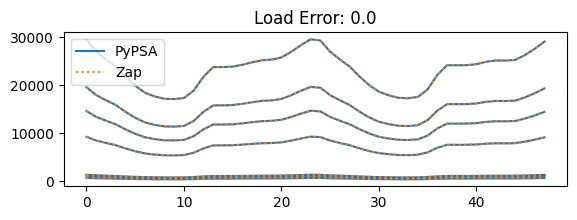

In [24]:
load_device = [d for d in devices if isinstance(d, zap.Load)][0]
num_loads = load_device.num_devices

pypsa_loads = pn.loads_t["p_set"].values
zap_loads = (load_device.load * load_device.nominal_capacity).T

fig, ax = plt.subplots(figsize=(6.5, 2))

ax.set_title(f"Load Error: {np.sum(np.abs(pypsa_loads - zap_loads))}")
ax.plot(pypsa_loads, c="C0", label=["PyPSA"] + [""]*(num_loads-1))
ax.plot(zap_loads, ls=":", c="C1", label=["Zap"] + [""]*(num_loads-1))
ax.legend()

plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (136,) and arg 1 with shape (176,).

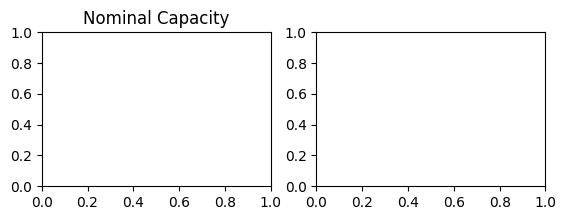

In [32]:
# Plot generator nominal capacities and capacity factors
gen_device = [d for d in devices if isinstance(d, zap.Generator)][0]
num_gens = gen_device.num_devices

pypsa_capacity_factor = pn.generators_t.p_max_pu.values
pypsa_nominal_capacities = pn.generators.p_nom.values
zap_capacity_factors = gen_device.max_power.T
zap_nominal_capacities = gen_device.nominal_capacity[:]

fig, axes = plt.subplots(1, 2, figsize=(6.5, 2))

ax = axes[0]
ax.set_title("Nominal Capacity")
ax.bar(range(num_gens), pypsa_nominal_capacities)

plt.show()

print(num_gens)
print(pypsa_nominal_capacities.shape)
print(zap_nominal_capacities.shape)

In [ ]:
# Plot tx capacities

In [18]:
pn.generators.p_nom.values

array([3.8390e+02, 1.2000e+00, 5.3640e+02, 9.6038e+03, 2.7597e+03,
       6.7000e+00, 7.5800e+01, 7.3554e+03, 3.3645e+03, 1.7032e+03,
       8.0700e+02, 5.4000e+01, 2.0968e+03, 2.6296e+03, 4.3288e+03,
       3.9153e+03, 4.2000e+00, 3.6000e+00, 5.2000e+00, 2.3810e+02,
       1.0494e+03, 9.3960e+02, 7.0340e+02, 1.1400e+02, 2.3796e+03,
       1.0000e+01, 1.4960e+02, 5.9000e+01, 4.1813e+03, 1.5463e+03,
       3.2000e+00, 2.4300e+03, 4.0946e+03, 4.4980e+02, 3.4494e+03,
       2.5570e+02, 5.0024e+03, 4.8000e+01, 4.0000e+00, 8.9920e+02,
       3.2249e+03, 2.1814e+03, 4.5200e+01, 3.2000e+00, 8.0000e+01,
       6.8200e+01, 0.0000e+00, 2.2664e+03, 5.3629e+03, 1.6738e+03,
       8.0000e+00, 1.6900e+03, 3.0210e+02, 0.0000e+00, 7.2800e+01,
       6.3130e+03, 1.6229e+03, 6.2240e+02, 2.7086e+03, 0.0000e+00,
       6.9300e+01, 1.8161e+03, 1.4368e+03, 5.7500e+02, 2.4704e+03,
       4.4000e+00, 1.8985e+03, 2.6820e+02, 1.2825e+03, 1.9563e+03,
       6.0560e+02, 2.3500e+01, 4.5600e+01, 0.0000e+00, 5.5400e

In [12]:
results = net.dispatch(devices=devices, time_horizon=48, solver=cp.CLARABEL)

In [13]:
device_index = 0
results.power[0][0].shape

(136, 48)

In [14]:
zap_pypsa = zap.exporters.export_to_pypsa(net, devices, results, snapshots=pn.snapshots)
zap_pypsa

/Users/degleris/Documents/code/zap/zap/exporters/pypsa.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  n.generators_t[attr][name] = df.loc[name]
/Users/degleris/Documents/code/zap/zap/exporters/pypsa.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  n.generators_t[attr][name] = df.loc[name]
/Users/degleris/Documents/code/zap/zap/exporters/pypsa.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

PyPSA Network
Components:
 - Bus: 7
 - Generator: 136
 - Line: 12
 - Load: 7
 - StorageUnit: 14
Snapshots: 48

In [15]:
zap_pypsa.buses_t.marginal_price

bus0         bus1         bus2  \
period timestep                                                     
2050   2050-02-01 00:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-01 01:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-01 02:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-01 03:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-01 04:00:00    39.263485    39.263485    39.263485   
       2050-02-01 05:00:00    36.190174    36.190174    36.190174   
       2050-02-01 06:00:00    34.529736    34.529736    34.529736   
       2050-02-01 07:00:00    34.529731    34.529731    34.529731   
       2050-02-01 08:00:00    34.529731    34.529731    34.529731   
       2050-02-01 09:00:00    34.529731    34.529731    34.529731   
       2050-02-01 10:00:00    34.529731    34.529731    34.529731   
       2050-02-01 11:00:00    36.190174    36.190174    36.190174   
       2050-02-01 12:00:00    39.263485    39.263485    39.263485   
       2050-02-01 13:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-01 14:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-01 15:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-01 16:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-01 17:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-01 18:00:00  1000.000000  1000.000000   999.999999   
       2050-02-01 19:00:00   999.999999  1000.000000   999.999999   
       2050-02-01 20:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-01 21:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-01 22:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-01 23:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-02 00:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-02 01:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-02 02:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-02 03:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-02 04:00:00    39.263485    39.263485    39.263485   
       2050-02-02 05:00:00    36.190174    36.190174    36.190174   
       2050-02-02 06:00:00    36.190174    36.190174    36.190174   
       2050-02-02 07:00:00    36.190172    36.190172    36.190171   
       2050-02-02 08:00:00    36.190171    36.190171    36.190171   
       2050-02-02 09:00:00    36.190171    36.190171    36.190171   
       2050-02-02 10:00:00    36.190171    36.190171    36.190171   
       2050-02-02 11:00:00    36.190174    36.190174    36.190174   
       2050-02-02 12:00:00   999.999993   999.999993   999.999993   
       2050-02-02 13:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-02 14:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-02 15:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-02 16:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-02 17:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-02 18:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-02 19:00:00   999.999999   999.999999   999.999999   
       2050-02-02 20:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-02 21:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-02 22:00:00  1000.000000  1000.000000  1000.000000   
       2050-02-02 23:00:00  1000.000000  1000.000000  1000.000000   

                                   bus3         bus4         bus5         bus6  
period timestep                                                                 
2050   2050-02-01 00:00:00  1000.000000  1000.000000  1000.000000  1000.000000  
       2050-02-01 01:00:00  1000.000000  1000.000000  1000.000000  1000.000000  
       2050-02-01 02:00:00  1000.000000  1000.000000  1000.000000  1000.000000  
       2050-02-01 03:00:00  1000.000000  1000.000000  1000.000000  1000.000000  
       2050-02-01 04:00:00    39.263485    39.263485    39.263485    39.263485  
       2050-02-01